In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
import umap.umap_ as umap
import string 
import time
from gensim import corpora
import gensim

In [2]:
ntopic = 20
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/niiggee/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
#!pip install stop_words

  Preparing metadata (setup.py) ... done
  Created wheel for stop_words: filename=stop_words-2018.7.23-py3-none-any.whl size=32893 sha256=2b9f006f773e6175e4bf86dd81a6116baf4b593506cb7aa7c2ebf33c434c8f7c
  Stored in directory: /Users/niiggee/Library/Caches/pip/wheels/da/d8/66/395317506a23a9d1d7de433ad6a7d9e6e16aab48cf028a0f60
Successfully built stop_words


In [4]:
from stop_words import get_stop_words

stop_words = get_stop_words('en')

In [5]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train')

In [6]:
from pprint import pprint
num_topics = len( set(newsgroups_train.target_names) )
print("num_topics : ",num_topics )
pprint(list(newsgroups_train.target_names))

num_topics :  20
['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']


In [8]:

#Append sentences from newsgroup documents to raw sentences
raw_sentences = []
for s in newsgroups_train.data:
  raw_sentences.append( s )

In [9]:


def only_letters(tested_string):
    for letter in tested_string:
        if letter not in "abcdefghijklmnopqrstuvwxyz":
            return False
    return True

#I just did an adhoc cleaning, as I see documents
#have some non English characters, so I use above method only_letters
#to filter instead of default isalpha python method
def clean_data(s): 
    s = s.replace(">","").lower()
    if "lines:" in s :
        index = s.index("lines:")
        s = s[index+10:] 
        
    word_list = word_tokenize(s)
    cleaned = []
    for w in word_list:
        if w not in stop_words:
            if w in string.punctuation or only_letters(w):
                if w in string.punctuation or len( set(w) ) > 1:
                    cleaned.append( w)
    return " ".join(cleaned) ,cleaned           
            

#from documents clean sentence and return vocublary of sentence
def build_data(docs):

    n_docs = len(docs)
    sentences = []  # sentences
    token_lists = []  # words vocublary
    
    for i in range(len(docs)):
        sentence,token_list = clean_data(docs[i])
        if token_list: #if not all items eleminated
            sentences.append(sentence)
            token_lists.append(token_list)
        
    return sentences, token_lists

In [12]:
#sentences, token_lists = build_data(raw_sentences )

In [22]:
#token_lists

[['wondering',
  'anyone',
  'enlighten',
  'car',
  'saw',
  'day',
  '.',
  'sports',
  'car',
  ',',
  'looked',
  'late',
  'early',
  '.',
  'called',
  'bricklin',
  '.',
  'doors',
  'really',
  'small',
  '.',
  'addition',
  ',',
  'front',
  'bumper',
  'separate',
  'rest',
  'body',
  '.',
  'know',
  '.',
  'anyone',
  'can',
  'tellme',
  'model',
  'name',
  ',',
  'engine',
  'specs',
  ',',
  'years',
  'production',
  ',',
  'car',
  'made',
  ',',
  'history',
  ',',
  'whatever',
  'info',
  'funky',
  'looking',
  'car',
  ',',
  'please',
  '.',
  'thanks',
  ',',
  '-',
  'il',
  'brought',
  'neighborhood',
  'lerxst'],
 [':',
  'fair',
  'number',
  'brave',
  'souls',
  'upgraded',
  'si',
  'clock',
  'oscillator',
  'shared',
  'experiences',
  'poll',
  '.',
  'please',
  'send',
  'brief',
  'message',
  'detailing',
  'experiences',
  'procedure',
  '.',
  'top',
  'speed',
  'attained',
  ',',
  'cpu',
  'rated',
  'speed',
  ',',
  'add',
  'cards',
  '

In [15]:
#sentences[2]

'well folks , mac plus finally gave ghost weekend starting life way back sooo , market new machine bit sooner intended looking picking powerbook maybe bunch questions ( hopefully ) somebody can answer : * anybody know dirt next round powerbook introductions expected ? heard supposed make appearence summer heard anymore - since access macleak , wondering anybody info * anybody heard rumors price drops powerbook line like ones duo just went recently ? * impression display ? probably swing got disk rather , really feel much better display ( yea , looks great store , wow really good ? ) . solicit opinions people use worth taking disk size money hit get active display ? ( realize real subjective question , played around machines computer store breifly figured opinions somebody actually uses machine daily might prove helpful ) . * well hellcats perform ? ; ) thanks bunch advance info - email , post summary ( news reading time premium finals just around corner : ( ) tom willis \\ twillis @ \\

In [35]:
import pandas as pd
input_path = "/Users/niiggee/Desktop/SCHOOLWORK/Y4S2/DSA4265/datasets/"
reviews = input_path + "reviews.csv"
df = pd.read_csv(reviews)
df.head()
data = list(df['Text'])

In [36]:
sentences, token_lists = build_data(data )

In [37]:
sentences[2]

'educated feline nutrition , allowed cats become addicted dry cat food . always offered canned dry , wish fed premium quality canned food limited dry food . two year old cats two year old cats . good quality dry foods will eat wellness innova . innova manufacturer recently purchased procter & gamble . began looking replacement . offering several samples ( local holistic pet store ) holistic select one ( usual wellness innova ) eat . finicky cats , recommend trying holistic select . good quality food palatable finicky eaters .'

In [ ]:
token_lists[2]

In [39]:
#get tfidf of documents
def get_tfidf_embedding(items):
  tfidf = TfidfVectorizer()
  embeddings = tfidf.fit_transform(items)
  return embeddings

In [40]:
#Generate embedding with tfidf
embedding_tf_idf = get_tfidf_embedding( sentences )
print("Shape of sentences applied tf-idf :", embedding_tf_idf.shape)

Shape of sentences applied tf-idf : (5444, 12005)


In [41]:
print("Type of tf-idf vector :", type( embedding_tf_idf[10] ) )
print("Sample of tf-idf vector :",  embedding_tf_idf[10] ) 
#you can see tf-idf scores for row 10

Type of tf-idf vector : <class 'scipy.sparse._csr.csr_matrix'>
Sample of tf-idf vector :   (0, 995)	0.2661841454688301
  (0, 7619)	0.2172748811362465
  (0, 3901)	0.2735064973984656
  (0, 4940)	0.29813074004318507
  (0, 1405)	0.22682699940618872
  (0, 3816)	0.25012480155503786
  (0, 3895)	0.3774583161795831
  (0, 10586)	0.18243570791763383
  (0, 1752)	0.23073030609506037
  (0, 7204)	0.24970733638952303
  (0, 10568)	0.11708184039767075
  (0, 7830)	0.2667567369722144
  (0, 4176)	0.18879399752326947
  (0, 11587)	0.21155375539453092
  (0, 7081)	0.3072653931476125
  (0, 4504)	0.12110204673360055
  (0, 4857)	0.19633129633677612


In [42]:
def predict_topics_with_kmeans(embeddings,num_topics):
  kmeans_model = KMeans(num_topics)
  kmeans_model.fit(embeddings)
  topics_labels = kmeans_model.predict(embeddings)
  return topics_labels


    
def plot_embeddings(embedding, labels,title):

    labels = np.array( labels )
    distinct_labels =  set( labels )
    
    n = len(embedding)
    counter = Counter(labels)
    for i in range(len( distinct_labels )):
        ratio = (counter[i] / n )* 100
        cluster_label = f"cluster {i}: { round(ratio,2)}"
        x = embedding[:, 0][labels == i]
        y = embedding[:, 1][labels == i]
        plt.plot(x, y, '.', alpha=0.4, label= cluster_label)
    plt.legend(title="Topic",loc = 'upper left', bbox_to_anchor=(1.01,1))
    plt.title(title)
    

def reduce_umap(embedding):
  reducer = umap.UMAP() #umap.UMAP()
  embedding_umap = reducer.fit_transform( embedding  )
  return embedding_umap

def reduce_pca(embedding):
    pca = PCA(n_components=2)
    reduced = pca.fit_transform( embedding )
    print( "pca explained_variance_ ",pca.explained_variance_)
    print( "pca explained_variance_ratio_ ",pca.explained_variance_ratio_)
    
    return reduced

def reduce_tsne(embedding):
    tsne = TSNE(n_components=2)
    reduced = tsne.fit_transform( embedding )
    
    return reduced

In [43]:
#Apply kmeans to raw vectors
labels_tfidf_raw  = predict_topics_with_kmeans(embedding_tf_idf,num_topics)

In [44]:
print("Embedding Tf-idf shape :",embedding_tf_idf.shape)

Embedding Tf-idf shape : (5444, 12005)


In [45]:
#Apply kmeans to umap vectors
embedding_tf_idf_umap =  reduce_umap( embedding_tf_idf )
labels_tfidf_umap  = predict_topics_with_kmeans(embedding_tf_idf_umap,num_topics)

In [46]:
print("Embedding shape after umap",embedding_tf_idf_umap.shape)

Embedding shape after umap (5444, 2)


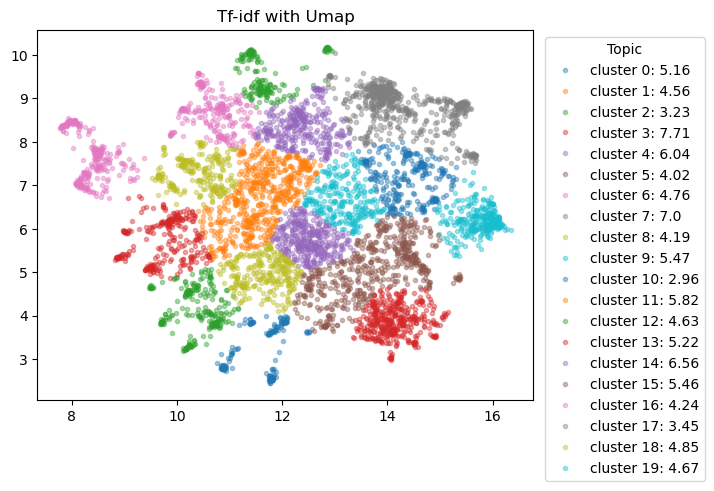

In [47]:
plot_embeddings(embedding_tf_idf_umap,labels_tfidf_umap,"Tf-idf with Umap")

/Users/niiggee/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/niiggee/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


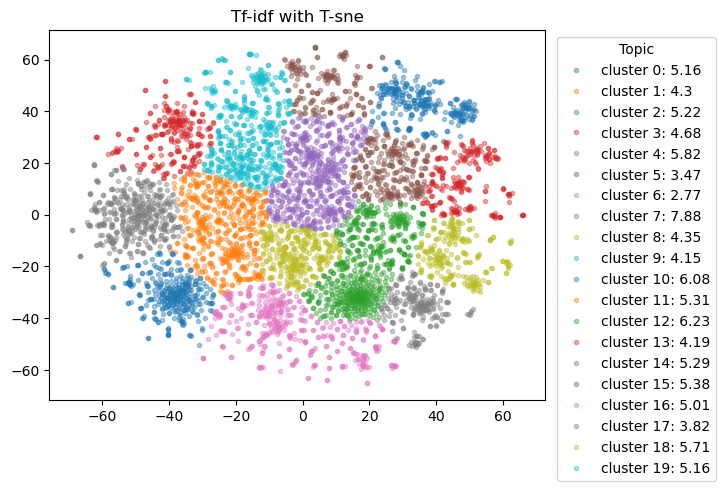

In [48]:
embedding_tf_idf_tsne =  reduce_tsne( embedding_tf_idf )
labels_tfidf_tsne  = predict_topics_with_kmeans(embedding_tf_idf_tsne,num_topics)

plot_embeddings(embedding_tf_idf_tsne,labels_tfidf_tsne,"Tf-idf with T-sne")

In [49]:
print("Silhouette score:" )
print("without dim reduction :", silhouette_score(embedding_tf_idf , labels_tfidf_raw) )
print("with Tf-idf   Umap    :", silhouette_score(embedding_tf_idf_umap, labels_tfidf_umap) )
print("with Tf-idf   T-sne   :",  silhouette_score(embedding_tf_idf_tsne, labels_tfidf_tsne) )

Silhouette score:
without dim reduction : 0.010990201186369746
with Tf-idf   Umap    : 0.41368508
with Tf-idf   T-sne   : 0.366439


In [50]:
def get_document_topic_lda(model, corpus, k):
   n_doc = len(corpus)
   #init a vector of size number of docs x clusters
   document_topic_mapping = np.zeros((n_doc, k))
   for i in range(n_doc):
     # for each document create a vector of probability document belonging to topic
     for topic, prob in model.get_document_topics(corpus[i]):
       document_topic_mapping[i, topic] = prob

   return document_topic_mapping

In [52]:
print("Number of words in token list :", len( token_lists ))

Number of words in token list : 5444


In [51]:
dictionary = corpora.Dictionary(token_lists)
corpus = [dictionary.doc2bow(text) for text in token_lists]
k = ntopic
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=k, id2word=dictionary,passes=20)

embedding_lda = get_document_topic_lda(ldamodel, corpus, k)

In [53]:
labels_lda = []
for line in corpus :
  line_labels = sorted( ldamodel.get_document_topics( line ) , key=lambda x: x[1], reverse=True)
  #1st 0 is for selecting top item, and 2nd 0 is for index of tuple
  top_topic = line_labels[0][0]
  labels_lda.append(  top_topic)

In [54]:
np.array(labels_lda ).shape

(5444,)

In [56]:
embedding_umap_lda = reduce_umap(embedding_lda)

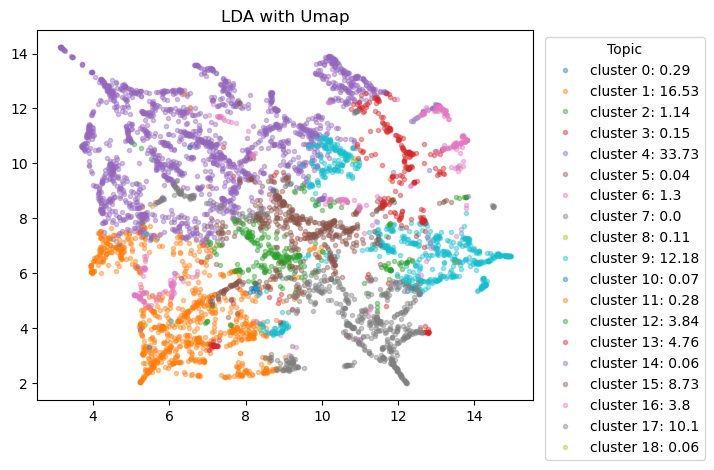

In [57]:
plot_embeddings(embedding_umap_lda, labels_lda,"LDA with Umap")

pca explained_variance_  [0.0801742  0.04653882]
pca explained_variance_ratio_  [0.2912899  0.16908543]


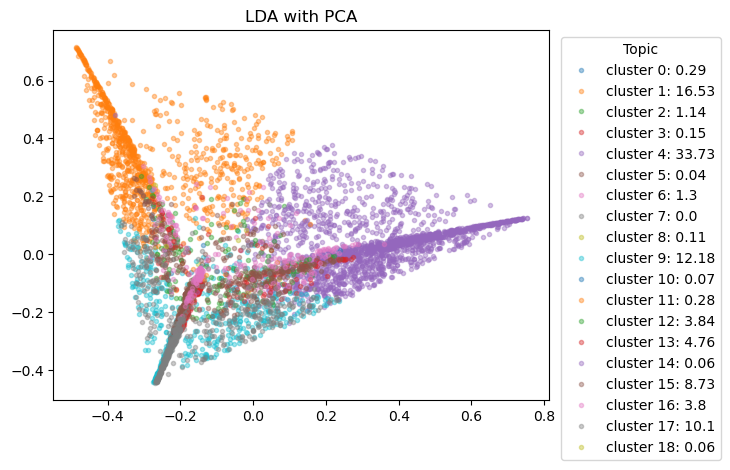

In [58]:
embedding_pca_lda = reduce_pca(embedding_lda  )
plot_embeddings(embedding_pca_lda, labels_lda,"LDA with PCA")

/Users/niiggee/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/niiggee/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


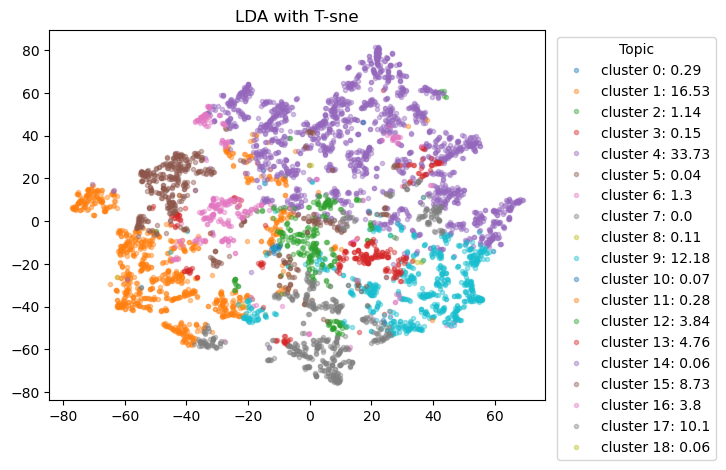

In [59]:
embedding_tsne_lda = reduce_tsne(embedding_lda  )
plot_embeddings(embedding_tsne_lda, labels_lda,"LDA with T-sne")

In [60]:
print("Silhouette score:" )
print("LDA          : ", silhouette_score(embedding_lda, labels_lda) )

print("LDA with PCA : ", silhouette_score(embedding_pca_lda, labels_lda) )

print("LDA with TSNE : ", silhouette_score(embedding_tsne_lda, labels_lda) )

print("LDA with UMAP : ", silhouette_score(embedding_umap_lda, labels_lda) )

Silhouette score:
LDA          :  0.2509637661969205
LDA with PCA :  0.030844411055362845
LDA with TSNE :  -0.040425405
LDA with UMAP :  -0.057575163


In [ ]:
from sentence_transformers import SentenceTransformer
model_bert = SentenceTransformer('bert-base-nli-max-tokens')

In [ ]:
embedding_bert = np.array(model_bert.encode(sentences, show_progress_bar=True))

In [ ]:
#Bert embeddings are shape of 768
print("Bert Embedding shape", embedding_bert.shape)
print("Bert Embedding sample", embedding_bert[0][0:50])

In [ ]:
#Apply Kmeans without dimension reduction
#run with 10 topics first
labels_bert_raw  = predict_topics_with_kmeans(embedding_bert,10)

In [ ]:
#Apply Kmeans for Bert Vectors  with Umap  dimension reduction

embedding_umap_bert = reduce_umap( embedding_bert )
labels_bert_umap  = predict_topics_with_kmeans(embedding_umap_bert,num_topics)
plot_embeddings(embedding_umap_bert, labels_bert_umap,"Bert with Umap")

In [ ]:
#Apply Kmeans for Bert Vectors  with PCA  dimension reduction

embedding_bert_pca =  reduce_pca( embedding_bert )
labels_bert_pca  = predict_topics_with_kmeans(embedding_bert_pca,num_topics)

plot_embeddings(embedding_bert_pca,labels_bert_pca,"Bert with PCA")

In [ ]:
#Apply Kmeans for Bert Vectors  with T-sne  dimension reduction

embedding_bert_tsne =  reduce_tsne( embedding_bert )
labels_bert_tsne  = predict_topics_with_kmeans(embedding_bert_tsne,num_topics)
plot_embeddings(embedding_bert_tsne,labels_bert_tsne,"Bert with T-sne")

In [ ]:
print("Silhouette score:" )

print("Raw Bert" ,silhouette_score(embedding_bert, labels_bert_raw) )

print("Bert with PCA" ,  silhouette_score(embedding_bert_pca, labels_bert_pca) )

print("Bert with Tsne" , silhouette_score(embedding_bert_tsne, labels_bert_tsne) )


print("Bert with Umap" ,  silhouette_score(embedding_umap_bert , labels_bert_umap ) )